/tmp/ipykernel_113070/4111422060.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-12.47168779373169' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  residuals_clustered_si.loc[
/tmp/ipykernel_113070/4111422060.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.7013988941907883' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  residuals_clustered_si.loc[
/tmp/ipykernel_113070/4111422060.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-6.440472602844238' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  residuals_clustered_si.loc[
/tmp/ipykernel_113070/4111422060.py:89: FutureWarning: Setting an item of incompa

/tmp/ipykernel_113070/4111422060.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-12.47168779373169' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  residuals_clustered_si.loc[
/tmp/ipykernel_113070/4111422060.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.7013988941907883' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  residuals_clustered_si.loc[
/tmp/ipykernel_113070/4111422060.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-6.440472602844238' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  residuals_clustered_si.loc[
/tmp/ipykernel_113070/4111422060.py:89: FutureWarning: Setting an item of incompa

Max positive slope energy: 299.76
Max negative slope energy: 285.60


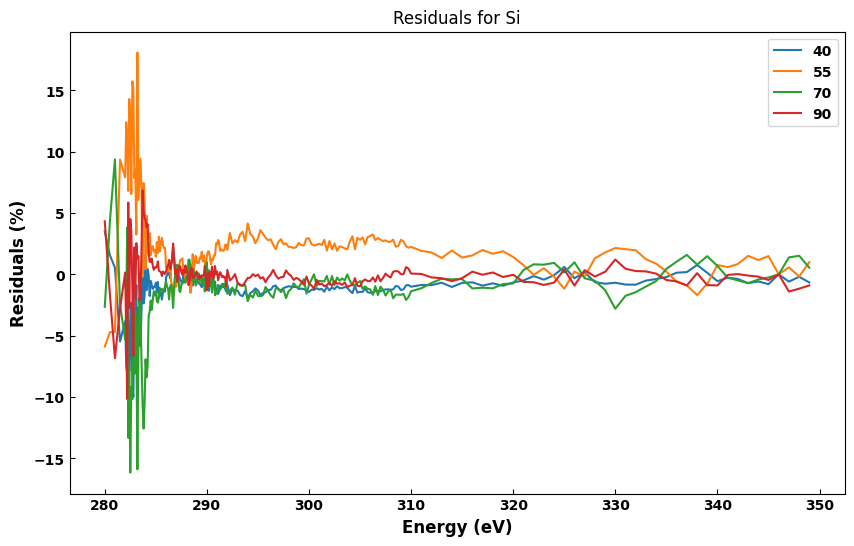

In [5]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from pathlib import Path


# Linear fit function
def linear_fit(x, a, b):
    return a * x + b


# Load the silicon dataset
dataset_path = Path().cwd()
dt_si = xr.open_datatree(
    dataset_path / "Model vs Exp Si for hdh.h5xp", engine="h5netcdf", phony_dims="sort"
)["/Packed Data"].to_dataset()

# Extract energy and spectra data
energy_si = dt_si["expEnergy1_alpha88"].to_numpy()
incident_angles = [40, 55, 70, 90]
exp_cols_si = {
    f"{angle}": dt_si[f"expSpec{i}_alpha88"].to_numpy()
    for i, angle in enumerate(incident_angles, start=1)
}
exp_cols_si["energy"] = energy_si
df_si = pd.DataFrame(exp_cols_si)

# Get fitted data
fitted_cols_si = {
    f"{angle}": dt_si[f"fitresults{i}_alpha88"].to_numpy()
    for i, angle in enumerate(incident_angles, start=1)
}
fitted_cols_si["energy"] = energy_si
df_fitted_si = pd.DataFrame(fitted_cols_si)

# Calculate residuals for cos²θ model
residuals_si = pd.DataFrame(
    {
        "energy": df_si["energy"],
        **{f"{angle}": [0] * len(df_si) for angle in incident_angles},
    }
)

# Calculate linear fits and residuals
optimal_si = []
for i, e in enumerate(energy_si):
    row = df_si.where(df_si["energy"] == e).dropna()
    x = incident_angles
    cos_x = np.cos(np.radians(x)) ** 2
    y = row[[f"{angle}" for angle in incident_angles]].values.flatten()

    # Calculate fit
    popt, pcov = curve_fit(
        linear_fit, cos_x, y, p0=[1, 0], bounds=([-np.inf, -np.inf], [np.inf, np.inf])
    )

    # Calculate residuals
    resid_abs = y - linear_fit(cos_x, *popt)
    resid_percentage = [(r / y_i) * 100 for r, y_i in zip(resid_abs, y) if y_i != 0]
    residuals_si.loc[
        residuals_si["energy"] == e, [f"{angle}" for angle in incident_angles]
    ] = resid_percentage

    optimal_si.append((e, *popt))

# Calculate residuals from the clustered fit
residuals_clustered_si = pd.DataFrame(
    {
        "energy": df_si["energy"],
        **{
            f"{angle}": dt_si[f"res{i}"].to_numpy()
            for i, angle in enumerate(incident_angles, start=0)
        },
    }
)

# Filter data to energy range 284-305 eV
energy_mask = (df_si["energy"] >= 284) & (df_si["energy"] <= 305)
df_si_filtered = df_si[energy_mask].copy()
df_fitted_si_filtered = df_fitted_si[energy_mask].copy()
energy_si_filtered = df_si_filtered["energy"].to_numpy()
residuals_si_filtered = residuals_si[energy_mask].copy()
residuals_clustered_si_filtered = residuals_clustered_si[energy_mask].copy()

# Convert optimal_si to DataFrame
optimal_si_df = pd.DataFrame(optimal_si, columns=["energy", "slope", "intercept"])
optimal_si_df = optimal_si_df[
    (optimal_si_df["energy"] >= 284.2) & (optimal_si_df["energy"] <= 300)
]

# Find key energies - peaks for π* and σ* regions
# For Silicon, we need to find the peaks - let's look for max positive and negative slopes
energy_array = optimal_si_df["energy"].values
slopes = optimal_si_df["slope"].values

# Find where the slope is maximum positive and maximum negative
pos_slope_idx = np.argmax(slopes)
neg_slope_idx = np.argmin(slopes)

max_positive_slope_energy = energy_array[pos_slope_idx]
max_negative_slope_energy = energy_array[neg_slope_idx]
print(f"Max positive slope energy: {max_positive_slope_energy:.2f}")
print(f"Max negative slope energy: {max_negative_slope_energy:.2f}")

df_si.plot(
    x="energy",
    y=[f"{angle}" for angle in incident_angles],
    title="Experimental Si Spectra",
    xlabel="Energy (eV)",
    ylabel="Intensity (a.u.)",
    figsize=(10, 6),
)

/tmp/ipykernel_113070/3146865968.py:402: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


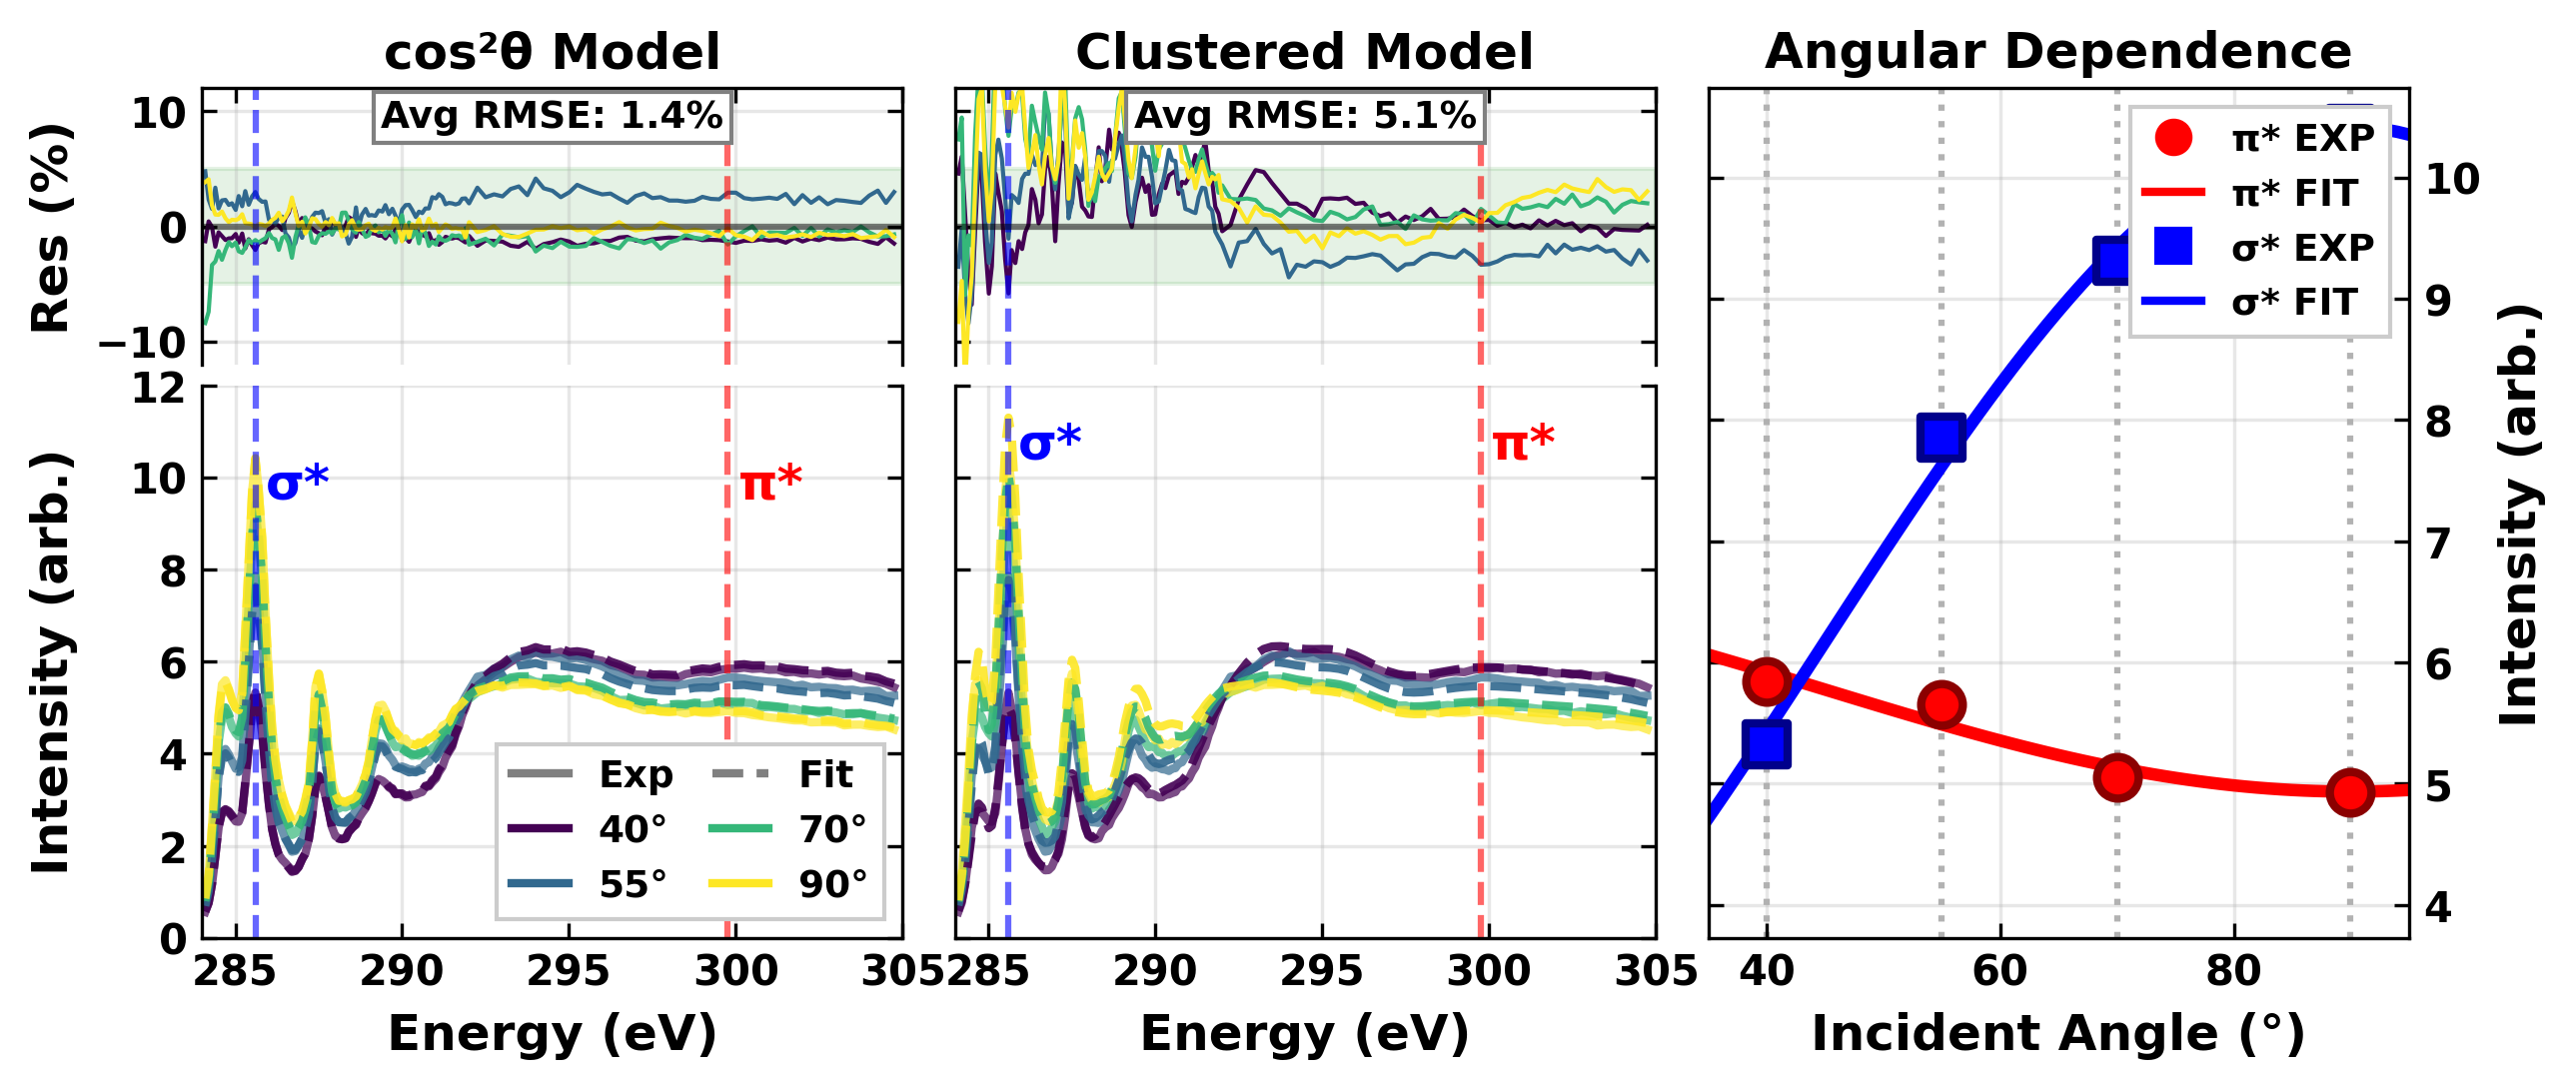

In [4]:
# Enhanced version with angular dependence plot for Si data
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.labelweight"] = "bold"

# Create figure with expanded layout for angular dependence panel
fig = plt.figure(figsize=(9.5, 3.5), dpi=300)

# Layout grid - reduced wspace to minimize white space between panels
gs = fig.add_gridspec(
    2,
    5,
    height_ratios=[1.5, 3],
    width_ratios=[2, 0.1, 2, 0.1, 2],
    hspace=0.05,
    wspace=0.02,
)

# Create the axes
ax_residuals = fig.add_subplot(gs[0, 0])
ax_data = fig.add_subplot(gs[1, 0], sharex=ax_residuals)
ax_residuals_hdf = fig.add_subplot(gs[0, 2], sharex=ax_residuals)
ax_data_hdf = fig.add_subplot(gs[1, 2], sharex=ax_residuals_hdf)
ax_angular = fig.add_subplot(gs[:, 4])

# Calculate RMSE values
rmse_cos_fit = {}
rmse_hdf_fit = {}
for angle in incident_angles:
    rmse_cos_fit[angle] = np.sqrt(np.mean(residuals_si_filtered[f"{angle}"] ** 2))
    rmse_hdf_fit[angle] = np.sqrt(
        np.mean(residuals_clustered_si_filtered[f"{angle}"] ** 2)
    )

avg_rmse_cos = np.mean(list(rmse_cos_fit.values()))
avg_rmse_hdf = np.mean(list(rmse_hdf_fit.values()))

# Colors for different angles
colors = plt.cm.viridis(np.linspace(0, 1, len(incident_angles)))

# Setup residual panels
for ax, residuals_data, title, avg_rmse in [
    (ax_residuals, residuals_si_filtered, "cos²θ Model", avg_rmse_cos),
    (
        ax_residuals_hdf,
        residuals_clustered_si_filtered,
        "Clustered Model",
        avg_rmse_hdf,
    ),
]:
    # Add shading for good fit region
    ax.axhspan(-5, 5, color="green", alpha=0.1, zorder=0)

    # Plot residuals for each angle
    for i, angle in enumerate(incident_angles):
        ax.plot(
            residuals_data["energy"],
            residuals_data[f"{angle}"],
            color=colors[i],
            linewidth=1,
            markersize=2,
        )

    # Highlight key energies
    ax.axvline(
        x=max_positive_slope_energy,
        color="red",
        linestyle="--",
        linewidth=1.5,
        alpha=0.6,
    )
    ax.axvline(
        x=max_negative_slope_energy,
        color="blue",
        linestyle="--",
        linewidth=1.5,
        alpha=0.6,
    )

    # Configure axis appearance
    ax.tick_params(
        axis="both", which="both", bottom=False, top=True, labelbottom=False, right=True
    )
    ax.spines["bottom"].set_visible(False)

    # Add title and RMSE info
    ax.set_title(title, fontweight="bold", pad=5)
    ax.text(
        294.5,
        9.5,
        f"Avg RMSE: {avg_rmse:.1f}%",
        fontsize=9,
        ha="center",
        va="center",
        bbox=dict(
            facecolor="white", alpha=1.0, boxstyle="square,pad=0.2", edgecolor="gray"
        ),
    )

    # Common settings
    ax.set_ylim(-12, 12)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color="black", linestyle="-", alpha=0.5)

# Add y-label only to left residual panel
ax_residuals.set_ylabel("Res (%)")
ax_residuals_hdf.set_yticklabels([])


# Define function to plot data
def plot_data(ax, df_data, df_fitted=None, is_cos_fit=True):
    # Plot experimental data for each angle
    for i, angle in enumerate(incident_angles):
        ax.plot(
            df_data["energy"],
            df_data[f"{angle}"] * 1e-4,  # Scale by 1e-4
            color=colors[i],
            linewidth=2,
            linestyle="-",
            alpha=0.7,
            label=f"Exp {angle}°",
        )

    # Create and plot fitted data
    if is_cos_fit:
        # Plot cos² fitted data
        for i, angle in enumerate(incident_angles):
            cos_angle = np.cos(np.radians(angle)) ** 2
            fitted_intensities = []

            for e in energy_si_filtered:
                opt_params = next(
                    (params for params in optimal_si if params[0] == e), None
                )
                if opt_params:
                    a, b = opt_params[1], opt_params[2]
                    fitted_intensities.append(linear_fit(cos_angle, a, b) * 1e-4)
                else:
                    fitted_intensities.append(np.nan)

            # Plot fitted data with dashed lines
            ax.plot(
                energy_si_filtered,
                fitted_intensities,
                color=colors[i],
                linewidth=2,
                linestyle="--",
                alpha=0.9,
                label=f"Fit {angle}°",
            )
    else:
        # For HDF5 data, the fit is already in df_fitted
        for i, angle in enumerate(incident_angles):
            ax.plot(
                df_fitted["energy"],
                df_fitted[f"{angle}"] * 1e-4,  # Scale by 1e-4
                color=colors[i],
                linewidth=2,
                linestyle="--",
                alpha=0.9,
                label=f"Fit {angle}°",
            )

    # Highlight the π* and σ* energies
    ax.axvline(
        x=max_positive_slope_energy,
        color="red",
        linestyle="--",
        linewidth=1.5,
        alpha=0.6,
    )
    ax.axvline(
        x=max_negative_slope_energy,
        color="blue",
        linestyle="--",
        linewidth=1.5,
        alpha=0.6,
    )

    # Add π* and σ* labels
    ymax = ax.get_ylim()[1]
    ax.text(
        max_positive_slope_energy + 0.3,
        ymax * 0.95,
        "π*",
        color="red",
        fontweight="bold",
        fontsize=12,
        verticalalignment="top",
    )
    ax.text(
        max_negative_slope_energy + 0.3,
        ymax * 0.95,
        "σ*",
        color="blue",
        fontsize=12,
        fontweight="bold",
        verticalalignment="top",
    )

    # Configure spine visibility
    ax.spines["top"].set_visible(False)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(284, 305)


# Plot data in both panels
plot_data(ax_data, df_si_filtered, is_cos_fit=True)
plot_data(
    ax_data_hdf, df_si_filtered, df_fitted=df_fitted_si_filtered, is_cos_fit=False
)

# Set axis labels
ax_data.set_ylabel("Intensity (arb.)")
ax_data_hdf.set_ylabel("")

# Set x-axis labels
ax_data.set_xlabel("Energy (eV)", fontsize=12)
ax_data_hdf.set_xlabel("Energy (eV)", fontsize=12)

# Set x-axis ticks and labels
energy_ticks = np.arange(285, 306, 5)
ax_data.set_xticks(energy_ticks)
ax_data.set_xticklabels([f"{int(e)}" for e in energy_ticks])
ax_data.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

# Set x-axis ticks for right panel
ax_data_hdf.set_xticks(energy_ticks)
ax_data_hdf.set_xticklabels([f"{int(e)}" for e in energy_ticks])
ax_data_hdf.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

# Determine appropriate y-axis scale for Si data
max_intensity = (
    max(
        df_si_filtered[[str(angle) for angle in incident_angles]].max().max(),
        df_fitted_si_filtered[[str(angle) for angle in incident_angles]].max().max(),
    )
    * 1e-4
)
y_max = np.ceil(max_intensity / 2) * 2  # Round up to next even number

# Set y-axis ticks and labels
intensity_ticks = np.linspace(0, y_max, 7)
ax_data.set_yticks(intensity_ticks)
ax_data.set_yticklabels([f"{tick:.0f}" for tick in intensity_ticks])
ax_data.tick_params(axis="y", which="both", right=True, labelleft=True)

# Set y-axis ticks for right panel (no labels)
ax_data_hdf.set_ylim(0, y_max)  # Ensure same y-limits as left panel
ax_data_hdf.set_yticks(intensity_ticks)
ax_data_hdf.set_yticklabels([])
ax_data_hdf.tick_params(axis="y", which="both", right=True, labelright=False)

# Set y-axis limits
ax_data.set_ylim(0, y_max)

# Create legend for data panels
legend_elements = []
for i, angle in enumerate(incident_angles):
    if i == 0:
        legend_elements.append(
            Line2D([0], [0], color="gray", linestyle="-", lw=2, label="Exp")
        )
    elif i == len(incident_angles) // 2:
        legend_elements.append(
            Line2D([0], [0], color="gray", linestyle="--", lw=2, label="Fit")
        )
    legend_elements.append(Line2D([0], [0], color=colors[i], lw=2, label=f"{angle}°"))

# Add legend to left data panel
ax_data.legend(
    handles=legend_elements,
    loc="lower right",
    fontsize=9,
    ncol=2,
    handlelength=1.5,
    columnspacing=1.0,
    title_fontsize=10,
    fancybox=False,
    framealpha=1,
)

# ======================
# Angular Dependence Panel
# ======================

# Get data for extreme slope energies
max_pos_data = df_si[df_si["energy"] == max_positive_slope_energy]
max_neg_data = df_si[df_si["energy"] == max_negative_slope_energy]

# Get corresponding fits
max_pos_params = next(
    (params for params in optimal_si if params[0] == max_positive_slope_energy), None
)
max_neg_params = next(
    (params for params in optimal_si if params[0] == max_negative_slope_energy), None
)

# Create angular data
cos_x = np.cos(np.radians(incident_angles)) ** 2
fine_angles = np.arange(30, 100, 1)
fine_cos_x = np.cos(np.radians(fine_angles)) ** 2

# Plot positive slope energy data and fit
max_pos_intensities = [
    max_pos_data[f"{angle}"].values[0] * 1e-4 for angle in incident_angles
]
ax_angular.scatter(
    incident_angles,
    max_pos_intensities,
    c="red",
    s=100,
    label=f"π* {max_positive_slope_energy:.1f} eV",
    marker="o",
    zorder=5,
    edgecolors="darkred",
    linewidth=2,
)
if max_pos_params:
    fit_pos = linear_fit(fine_cos_x, max_pos_params[1], max_pos_params[2]) * 1e-4
    ax_angular.plot(
        fine_angles,
        fit_pos,
        "r-",
        linewidth=3,
        label="π* fit",
    )

# Plot negative slope energy data and fit
max_neg_intensities = [
    max_neg_data[f"{angle}"].values[0] * 1e-4 for angle in incident_angles
]
ax_angular.scatter(
    incident_angles,
    max_neg_intensities,
    c="blue",
    s=100,
    label=f"σ* {max_negative_slope_energy:.1f} eV",
    marker="s",
    zorder=5,
    edgecolors="darkblue",
    linewidth=2,
)
if max_neg_params:
    fit_neg = linear_fit(fine_cos_x, max_neg_params[1], max_neg_params[2]) * 1e-4
    ax_angular.plot(
        fine_angles,
        fit_neg,
        "b-",
        linewidth=3,
        label="σ* fit",
    )

# Highlight the experimental angles
for angle in incident_angles:
    ax_angular.axvline(x=angle, color="gray", linestyle=":", alpha=0.6, zorder=1)

ax_angular.set_xlabel("Incident Angle (°)", fontsize=12)

# Move y-label to the right side
ax_angular.yaxis.set_label_position("right")
ax_angular.set_ylabel("Intensity (arb.)", fontsize=12)
ax_angular.tick_params(
    axis="y", which="both", left=True, right=True, labelleft=False, labelright=True
)

ax_angular.set_title("Angular Dependence", fontweight="bold", pad=5)

# Create legend for angular panel
angular_legend_elements = [
    Line2D(
        [0], [0], color="red", marker="o", markersize=8, linestyle="", label="π* EXP"
    ),
    Line2D([0], [0], color="red", linestyle="-", linewidth=2, label="π* FIT"),
    Line2D(
        [0], [0], color="blue", marker="s", markersize=8, linestyle="", label="σ* EXP"
    ),
    Line2D([0], [0], color="blue", linestyle="-", linewidth=2, label="σ* FIT"),
]

ax_angular.legend(
    handles=angular_legend_elements,
    fontsize=9,
    ncol=1,
    handlelength=1.5,
    columnspacing=1.0,
    title_fontsize=10,
    fancybox=False,
    framealpha=1,
    loc="upper right",
)

ax_angular.grid(True, alpha=0.3)
ax_angular.set_xlim(35, 95)
ax_angular.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

# Final layout adjustments
fig.align_ylabels()
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.05)
plt.show()

fig.savefig(
    "nexafs_angular_dependence_si.svg",
    bbox_inches="tight",
    format="svg",
    dpi=300,
    transparent=True,
)